In [311]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from lightgbm.basic import LightGBMError
from matplotlib.ticker import PercentFormatter
import treatment_utils as tu

In [312]:
# Lendo o arquivo CSV e criando coluna de "Vencedor da Partida"
df = pd.read_csv('Data/campeonatos_futebol_atualizacao.csv')

# Colunas adicionais que serão usadas na análise e no modelo
df["Vencedor"] = df.apply(lambda x: x["Time 1"] if x["Gols 1"] > x["Gols 2"] else x["Time 2"] if x["Gols 1"] < x["Gols 2"] else "Empate", axis=1)
df["Vitória em Casa"] = df.apply(lambda x: 1 if x["Vencedor"] == x["Time 1"] else 0 if x["Vencedor"] == x["Time 2"] else 0, axis=1)

# Definindo o estilo para combinar com o fundo branco que é o padrão, e suprimindo FutureWarnings
sns.set_style("white")
pd.set_option('future.no_silent_downcasting', True)

In [313]:
# Exibindo o dataset
df

,Chutes a gol 1,Chutes a gol 2,Impedimentos 1,Impedimentos 2,Escanteios 1,Escanteios 2,Chutes fora 1,Chutes fora 2,Faltas 1,Faltas 2,...,Defesas difíceis 1,Defesas difíceis 2,Posse 1(%),Posse 2(%),Time 1,Time 2,Position 1,Position 2,Vencedor,Vitória em Casa
0,8.0,0.0,6.0,3.0,7.0,1.0,6.0,1.0,8.0,14.0,...,NaN,NaN,77.0,23.0,Glasgow Rangers,Livingston,4-3-3,4-3-3,Glasgow Rangers,1
1,0.0,2.0,0.0,2.0,0.0,4.0,3.0,4.0,19.0,14.0,...,NaN,NaN,44.0,56.0,Ross County,St.Johnstone,3-5-2,3-5-2,Empate,0
2,4.0,5.0,1.0,5.0,8.0,11.0,2.0,5.0,13.0,14.0,...,NaN,NaN,47.0,53.0,Dundee FC,St. Mirren,4-3-3,3-4-1-2,Empate,0
3,4.0,7.0,8.0,1.0,6.0,5.0,4.0,7.0,4.0,11.0,...,NaN,NaN,27.0,73.0,Hearts,Celtic,3-4-3,4-2-3-1,Hearts,1
4,3.0,1.0,1.0,3.0,5.0,4.0,2.0,2.0,12.0,17.0,...,NaN,NaN,58.0,42.0,Aberdeen,Dundee U.,4-4-2,3-5-1-1,Aberdeen,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27711,6.0,2.0,1.0,0.0,9.0,6.0,6.0,5.0,7.0,7.0,...,NaN,NaN,52.0,48.0,Aston Villa,Blackburn,4-4-2,4-5-1,Blackburn,0
27712,6.0,0.0,4.0,3.0,4.0,2.0,8.0,2.0,11.0,9.0,...,NaN,NaN,52.0,48.0,Arsenal,Fulham,4-2-3-1,4-4-2,Arsenal,1
27713,7.0,7.0,2.0,3.0,10.0,2.0,8.0,0.0,10.0,6.0,...,NaN,NaN,55.0,45.0,Manchester Utd,Stoke,4-4-2,4-4-2,Manchester Utd,1
27714,6.0,6.0,1.0,2.0,4.0,3.0,4.0,6.0,5.0,3.0,...,NaN,NaN,45.0,55.0,West Ham,Manchester City,4-5-1,4-4-2,Empate,0


# Análise Exploratória de Dados

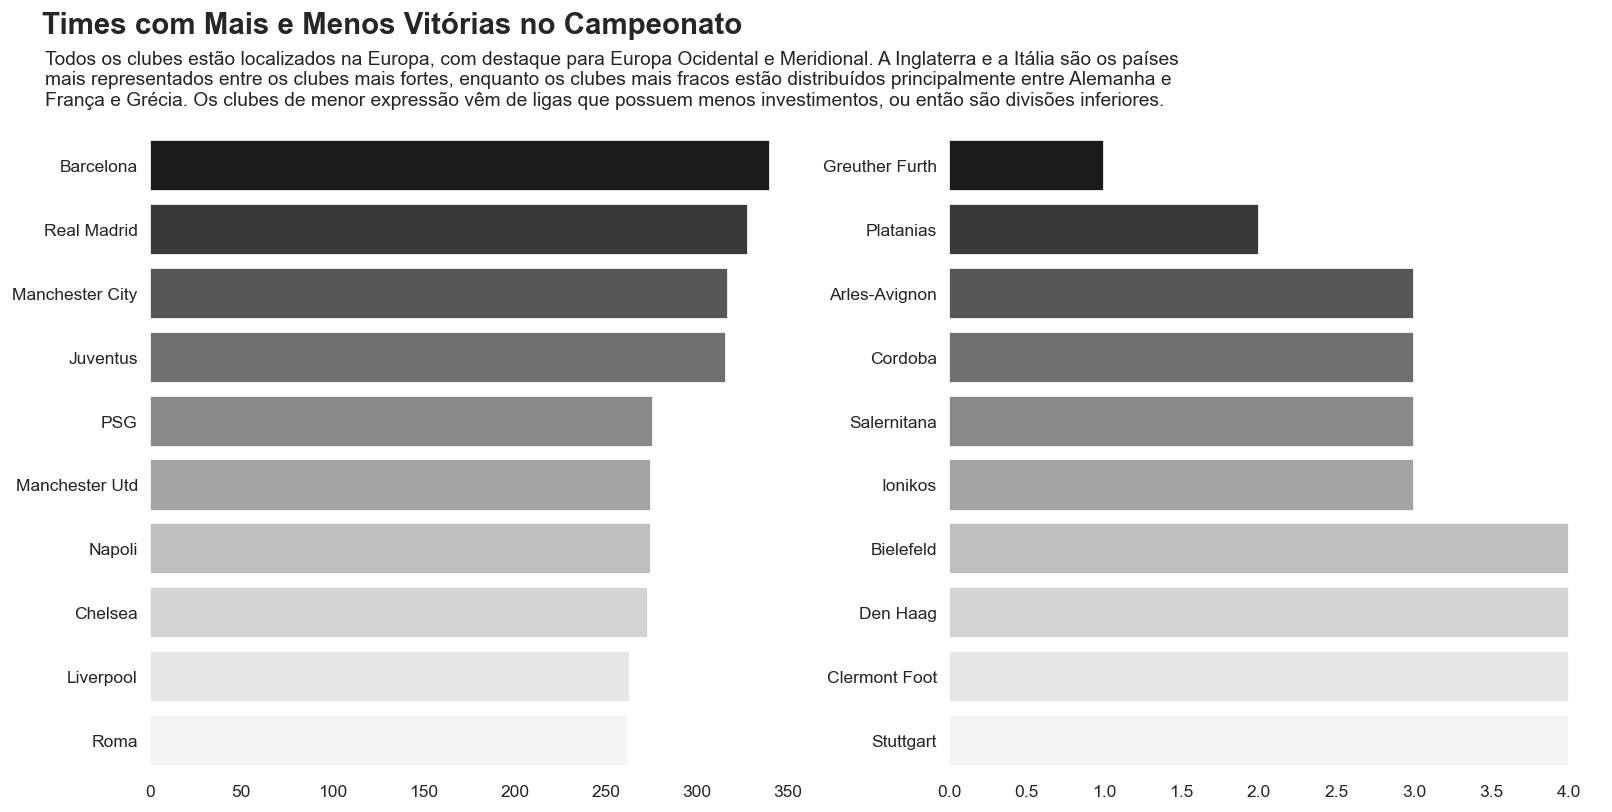

In [314]:
# Criação dos subplots
fig, axs = plt.subplots(1, 2, figsize=(13, 6), dpi=125)

for idx, bool in enumerate([False, True]):
    aux_top = df[df["Vencedor"] != "Empate"]["Vencedor"].value_counts(ascending = bool).head(10).reset_index()
    aux_top.columns = ["Vencedores", "Contagem"]
    sns.barplot(data=aux_top, y="Vencedores", x="Contagem", hue="Vencedores", legend=False, palette='Greys_r', ax=axs[idx])
    axs[idx].set_xlabel("")
    axs[idx].set_ylabel("")
    for spine in axs[idx].spines.values(): spine.set_visible(False)

# Título principal
fig.suptitle('Times com Mais e Menos Vitórias no Campeonato', x=0.03, ha="left", fontsize=17, fontweight='bold', y=1.075)
fig.text(0.0315, 0.95, 'Todos os clubes estão localizados na Europa, com destaque para Europa Ocidental e Meridional. A Inglaterra e a Itália são os países \nmais representados entre os clubes mais fortes, enquanto os clubes mais fracos estão distribuídos principalmente entre Alemanha e \nFrança e Grécia. Os clubes de menor expressão vêm de ligas que possuem menos investimentos, ou então são divisões inferiores.', fontsize=11)
plt.tight_layout()
plt.show()

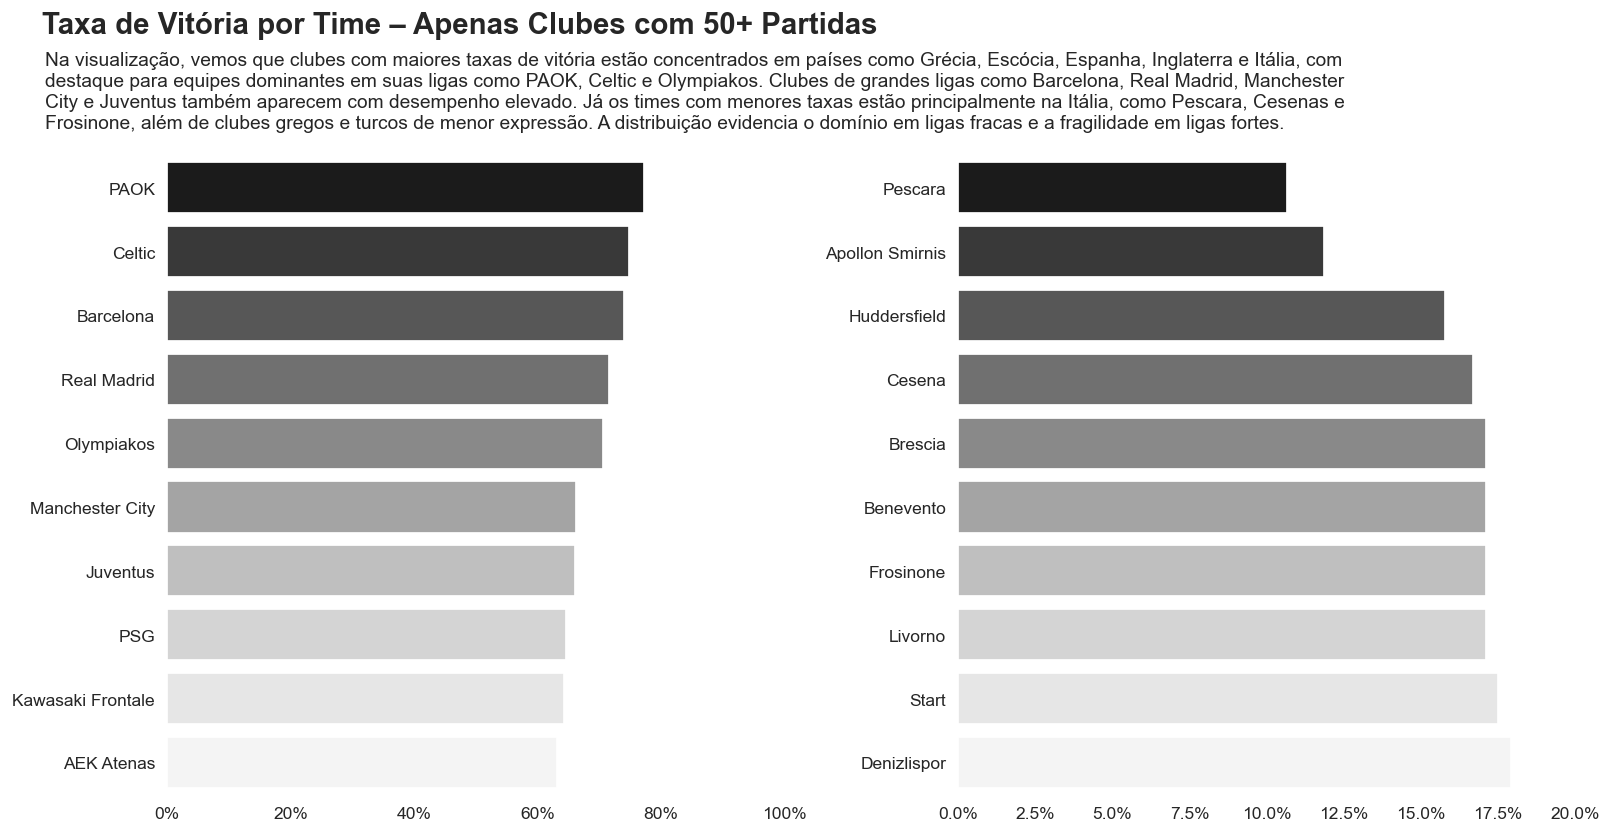

In [315]:
# Calculando a taxa de vitórias por time com pelo menos mais de 50 jogos
vitorias = df[df["Vencedor"] != "Empate"]["Vencedor"].value_counts()
jogos = pd.concat([df["Time 1"], df["Time 2"]]).value_counts()
proporcao = (vitorias / jogos[jogos > 50]).dropna().sort_values(ascending=False)
proporcao = (proporcao * 100).round(2)

# Criando subplots
fig, axs = plt.subplots(1, 2, figsize=(13, 6), dpi=125)

# Loop para Top e Bottom 10
for idx, ascending in enumerate([False, True]):
    aux = proporcao.sort_values(ascending=ascending).head(10).reset_index()
    aux.columns = ["Time", "Taxa de Vitória"]
    bars = sns.barplot(data=aux, y="Time", x="Taxa de Vitória", hue="Time", legend=False, palette='Greys_r', ax=axs[idx])
    
    # Estilização dos gráficos
    axs[idx].set_xlabel("")
    axs[idx].set_ylabel("")
    axs[idx].set_xlim(0, 100) if idx == 0 else axs[idx].set_xlim(0, 20)
    for spine in axs[idx].spines.values(): spine.set_visible(False)
    axs[idx].xaxis.set_major_formatter(PercentFormatter(xmax=100))

fig.suptitle('Taxa de Vitória por Time – Apenas Clubes com 50+ Partidas',x=0.03, ha="left", fontsize=17, fontweight='bold', y=1.105)
fig.text(0.0315, 0.95, f'Na visualização, vemos que clubes com maiores taxas de vitória estão concentrados em países como Grécia, Escócia, Espanha, Inglaterra e Itália, com \ndestaque para equipes dominantes em suas ligas como PAOK, Celtic e Olympiakos. Clubes de grandes ligas como Barcelona, Real Madrid, Manchester\nCity e Juventus também aparecem com desempenho elevado. Já os times com menores taxas estão principalmente na Itália, como Pescara, Cesenas e\nFrosinone, além de clubes gregos e turcos de menor expressão. A distribuição evidencia o domínio em ligas fracas e a fragilidade em ligas fortes.', fontsize=11)
plt.tight_layout()
plt.show()


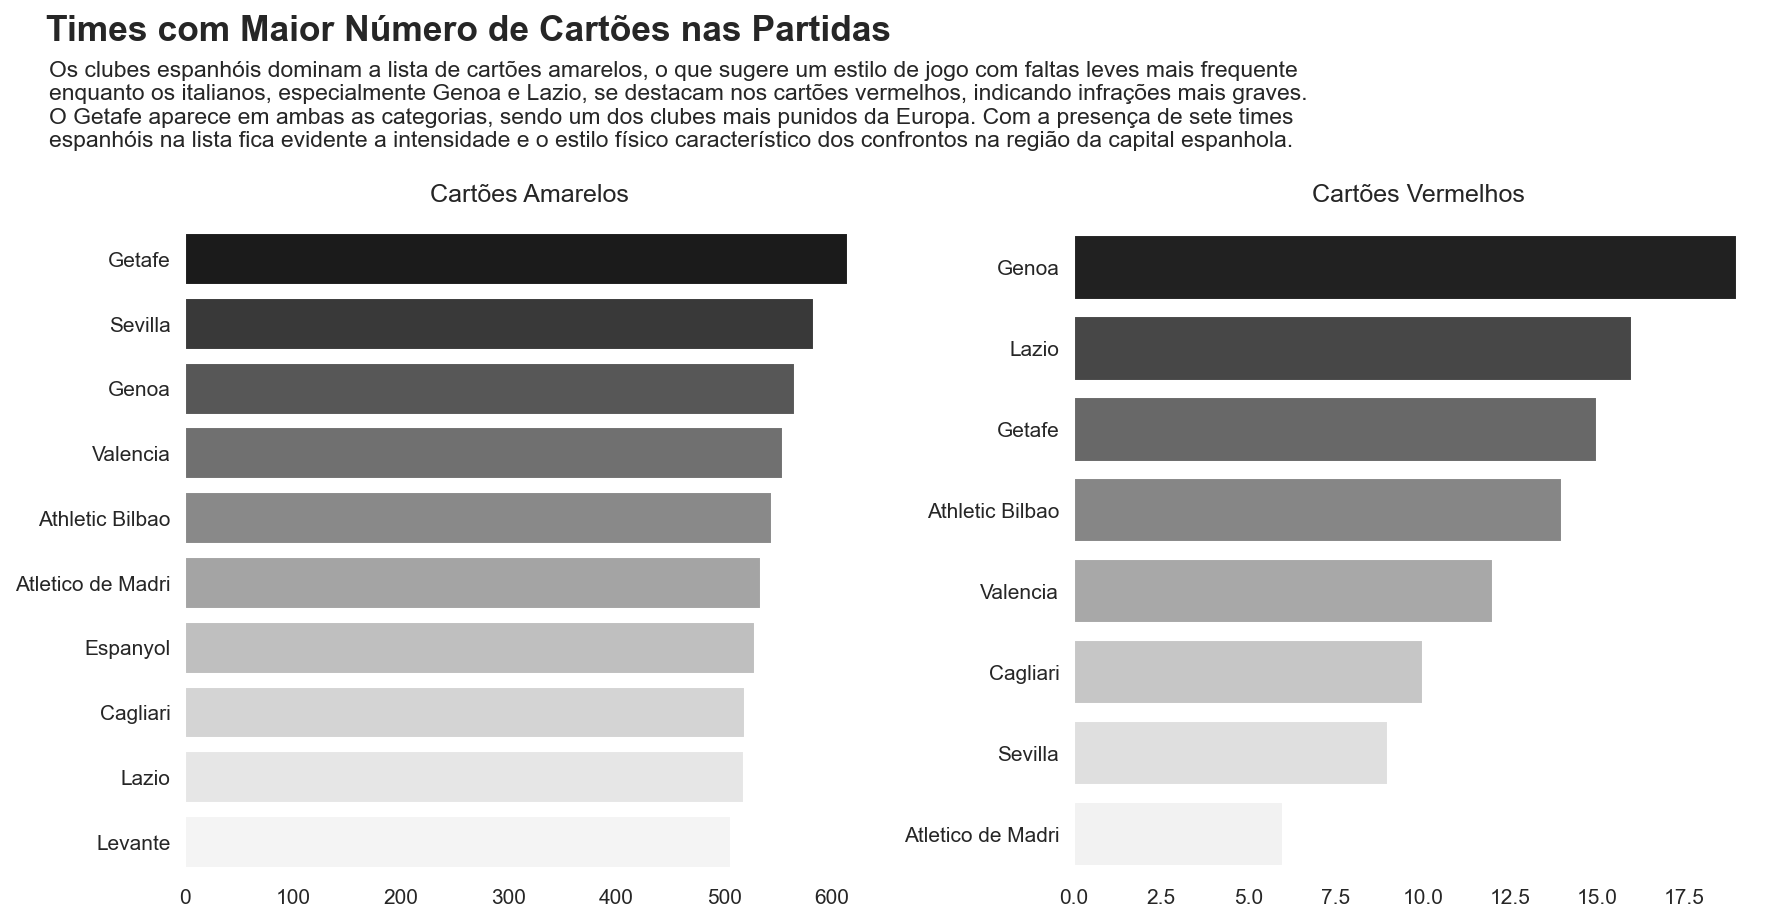

In [316]:
# Criando dataframe auxiliar agrupando os times e somando os seus diferentes tipos de cartões em diferentes colunas
lista_cartoes = ["Cartões amarelos 1", "Cartões vermelhos 1"]
aux = df.groupby("Time 1")[lista_cartoes].sum().reset_index()

fig, axs = plt.subplots(1, 2, dpi=150, figsize=(12, 5.5))
axs = axs.flatten()

# Criando o gráfico de barplot impedindo duplicatas em número de cartão para deixar mais interessante e aplicando cosméticos para deixar o visual mais "clean"
for idx, nome in enumerate(lista_cartoes):
    aux = aux.drop_duplicates(subset=[nome]).sort_values(by = nome, ascending = False).head(10)
    sns.barplot(data=aux, x=nome, y="Time 1", hue = "Time 1", legend = False, ax=axs[idx], palette="Greys_r")
    
    # Estilização dos plots
    axs[idx].set_title(nome.rstrip("1").title(), y = 1.02)
    axs[idx].set_ylabel('')
    axs[idx].set_xlabel('')
    for spine in axs[idx].spines.values():spine.set_visible(False)

fig.suptitle('Times com Maior Número de Cartões nas Partidas', x = 0.03, ha = "left", fontsize=17, fontweight='bold', y=1.11)
fig.text(0.0315, 0.95, f'Os clubes espanhóis dominam a lista de cartões amarelos, o que sugere um estilo de jogo com faltas leves mais frequente\nenquanto os italianos, especialmente Genoa e Lazio, se destacam nos cartões vermelhos, indicando infrações mais graves.\nO Getafe aparece em ambas as categorias, sendo um dos clubes mais punidos da Europa. Com a presença de sete times\nespanhóis na lista fica evidente a intensidade e o estilo físico característico dos confrontos na região da capital espanhola.', fontsize=11)
plt.tight_layout()
plt.show()

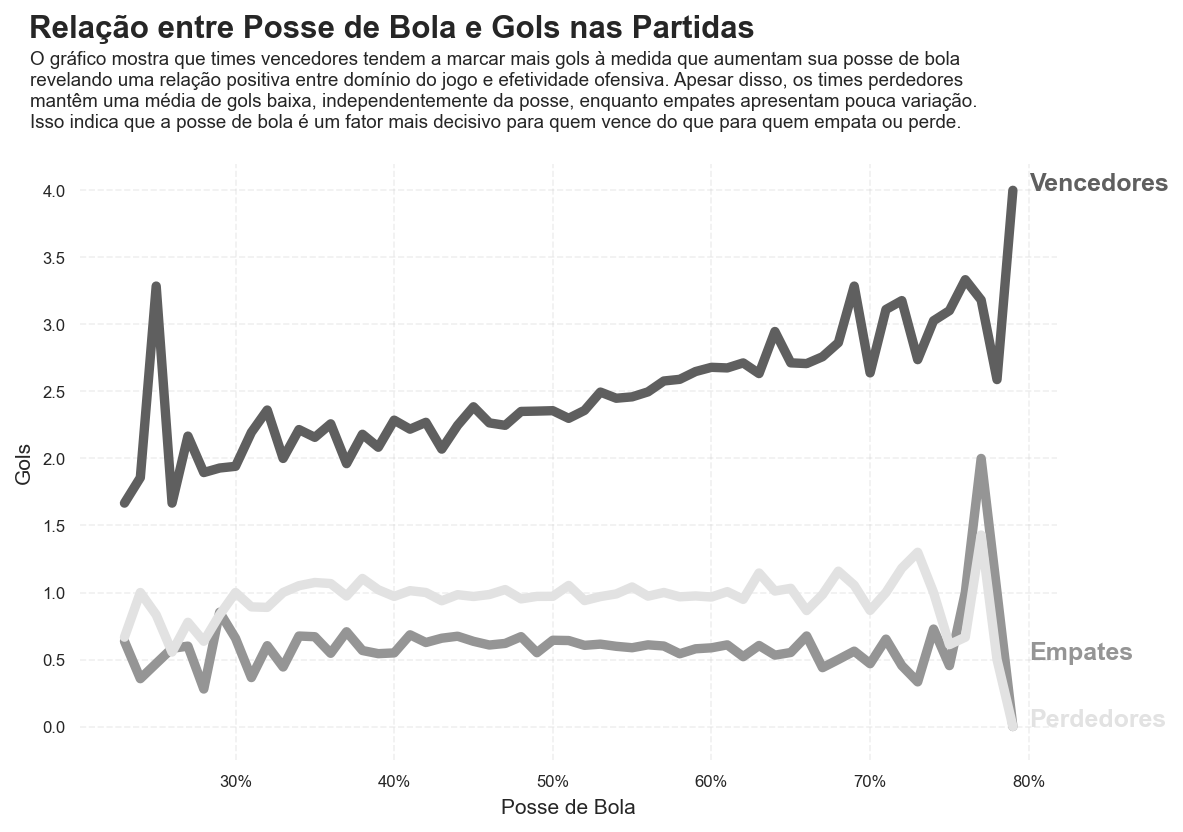

In [317]:
# Dataframe auxiliar que limita o escopo da posse de bola
aux = df[(df["Posse 1(%)"] > 22.0) & (df["Posse 1(%)"] < 80.0)]

# Criação de três lineplots para os times vencedores, perdedores e empates.
fig = plt.figure(figsize = (8,5), dpi = 150)
sns.lineplot(data = aux[aux['Time 1'] == aux["Vencedor"]], x="Posse 1(%)", y="Gols 1", linewidth = 4.5, color=plt.cm.Greys(0.7), errorbar=None)
plt.text(80, 4, "Vencedores", fontsize=12, fontfamily='sans-serif', fontweight='bold', color = plt.get_cmap('Greys')(0.7))
sns.lineplot(data = aux[(aux['Time 2'] == aux["Vencedor"])], x="Posse 1(%)", y="Gols 1", linewidth = 4.5, color=plt.cm.Greys(0.5), errorbar=None)
plt.text(80, 0.5, "Empates", fontsize=12, fontfamily='sans-serif', fontweight='bold', color = plt.get_cmap('Greys')(0.5))
sns.lineplot(data = aux[(aux["Vencedor"] == "Empate")], x="Posse 1(%)", y="Gols 1", linewidth = 4.5, color=plt.cm.Greys(0.2), errorbar=None)
plt.text(80, 0, "Perdedores", fontsize=12, fontfamily='sans-serif', fontweight='bold', color = plt.get_cmap('Greys')(0.2))

# Estilização do gráfico
ax = plt.gca()
for spine in ax.spines.values():spine.set_visible(False)
ax.grid(True, linestyle='--', alpha=0.3)
ax.set_ylim(-0.25, 4.2)
ax.set_xlabel("Posse de Bola")
ax.set_ylabel("Gols")
ax.xaxis.set_major_formatter(PercentFormatter(xmax=100))
ax.tick_params(axis='both', which='major', labelsize=8)

fig.suptitle('Relação entre Posse de Bola e Gols nas Partidas', x = 0.03, ha = "left", fontsize=15, fontweight='bold', y=1.1)
fig.text(0.0315, 0.95, f'O gráfico mostra que times vencedores tendem a marcar mais gols à medida que aumentam sua posse de bola\nrevelando uma relação positiva entre domínio do jogo e efetividade ofensiva. Apesar disso, os times perdedores\nmantêm uma média de gols baixa, independentemente da posse, enquanto empates apresentam pouca variação.\nIsso indica que a posse de bola é um fator mais decisivo para quem vence do que para quem empata ou perde. ', fontsize=9)
plt.tight_layout()
plt.show()

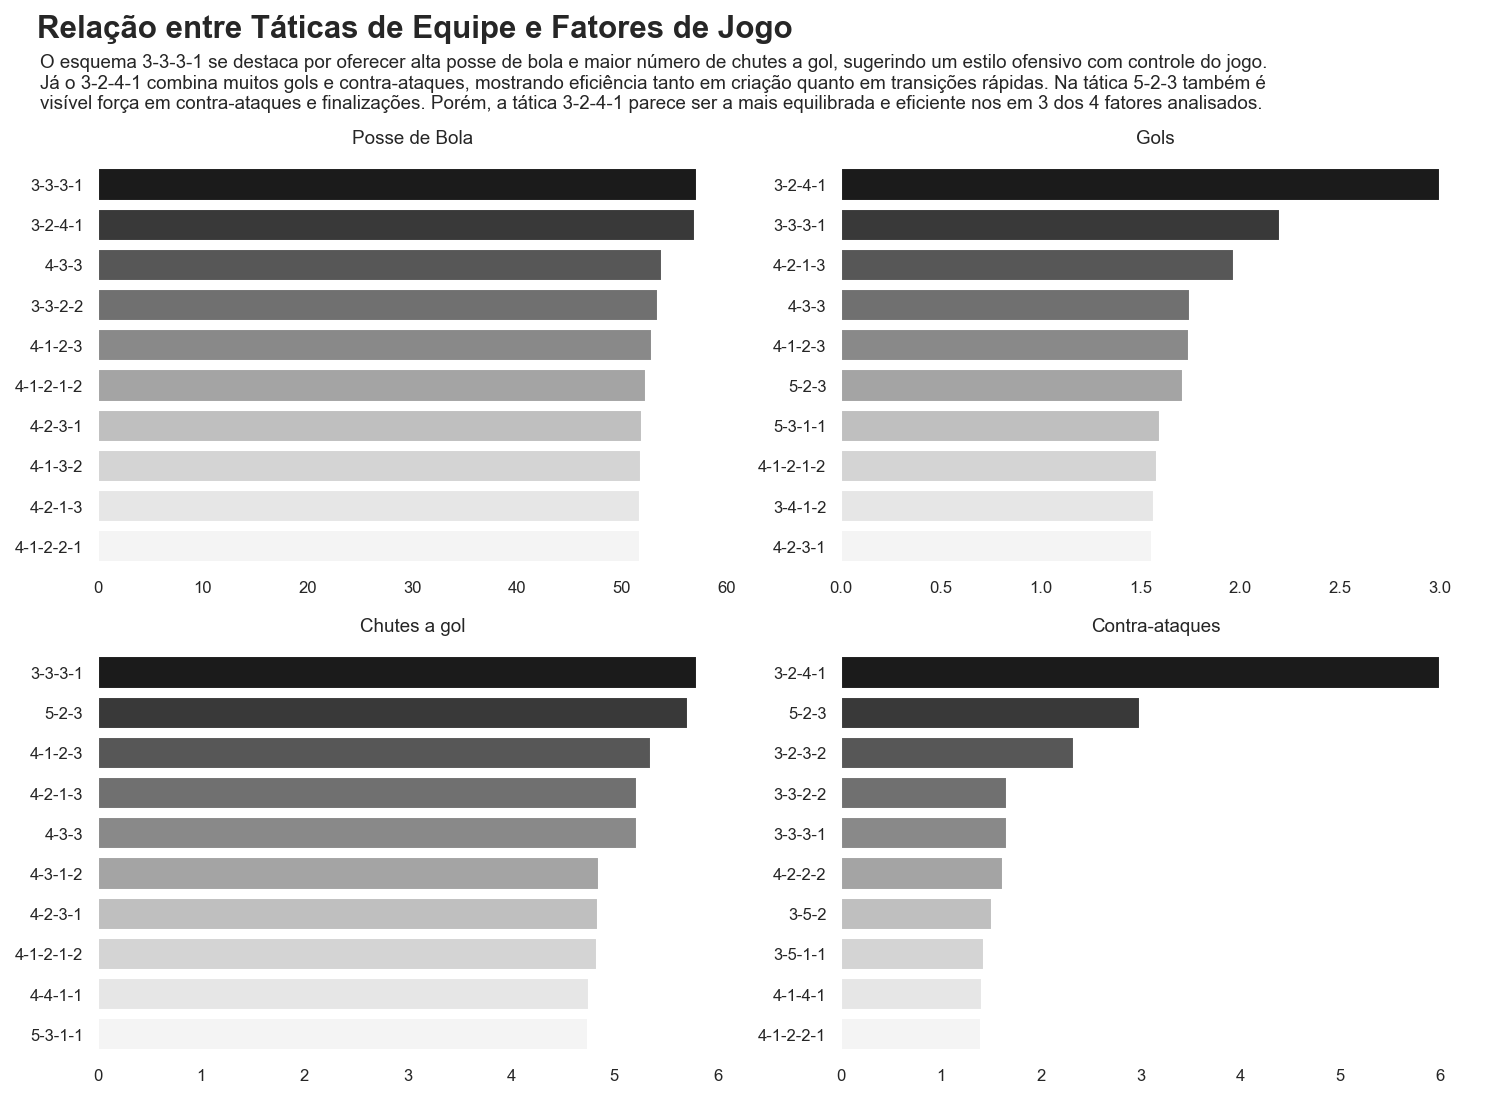

In [318]:
# Lista com as colunas interessantes e titulos à serem usados
lista_elementos = ["Posse 1(%)", "Gols 1", "Chutes a gol 1", "Contra-ataques 1"]
lista_titulos = ["Posse de Bola", "Gols", "Chutes a gol", "Contra-ataques"]
fig, axs = plt.subplots(2, 2, figsize=(10, 7), dpi=150)
axs = axs.flatten()

# Criação dos 4 gráficos de barras
for idx, nome in enumerate(lista_elementos):
    aux = df.groupby("Position 1")[nome].mean().reset_index().sort_values(by=nome, ascending=False)
    bar_plot = sns.barplot(data=aux.head(10), x=nome, y="Position 1", ax=axs[idx], hue = "Position 1", palette = "Greys_r")
    
    # Estilização dos plots
    for spine in axs[idx].spines.values():spine.set_visible(False)
    axs[idx].set_ylabel("")
    axs[idx].set_xlabel("")
    axs[idx].tick_params(axis='both', labelsize=8)
    axs[idx].set_title(lista_titulos[idx], y = 1.02, fontsize = 9)

fig.suptitle('Relação entre Táticas de Equipe e Fatores de Jogo', x = 0.03, ha = "left", fontsize=15, fontweight='bold', y=1.04)
fig.text(0.0315, 0.95, f'O esquema 3-3-3-1 se destaca por oferecer alta posse de bola e maior número de chutes a gol, sugerindo um estilo ofensivo com controle do jogo.\nJá o 3-2-4-1 combina muitos gols e contra-ataques, mostrando eficiência tanto em criação quanto em transições rápidas. Na tática 5-2-3 também é\nvisível força em contra-ataques e finalizações. Porém, a tática 3-2-4-1 parece ser a mais equilibrada e eficiente nos em 3 dos 4 fatores analisados.', fontsize=9)
plt.tight_layout()
plt.show()

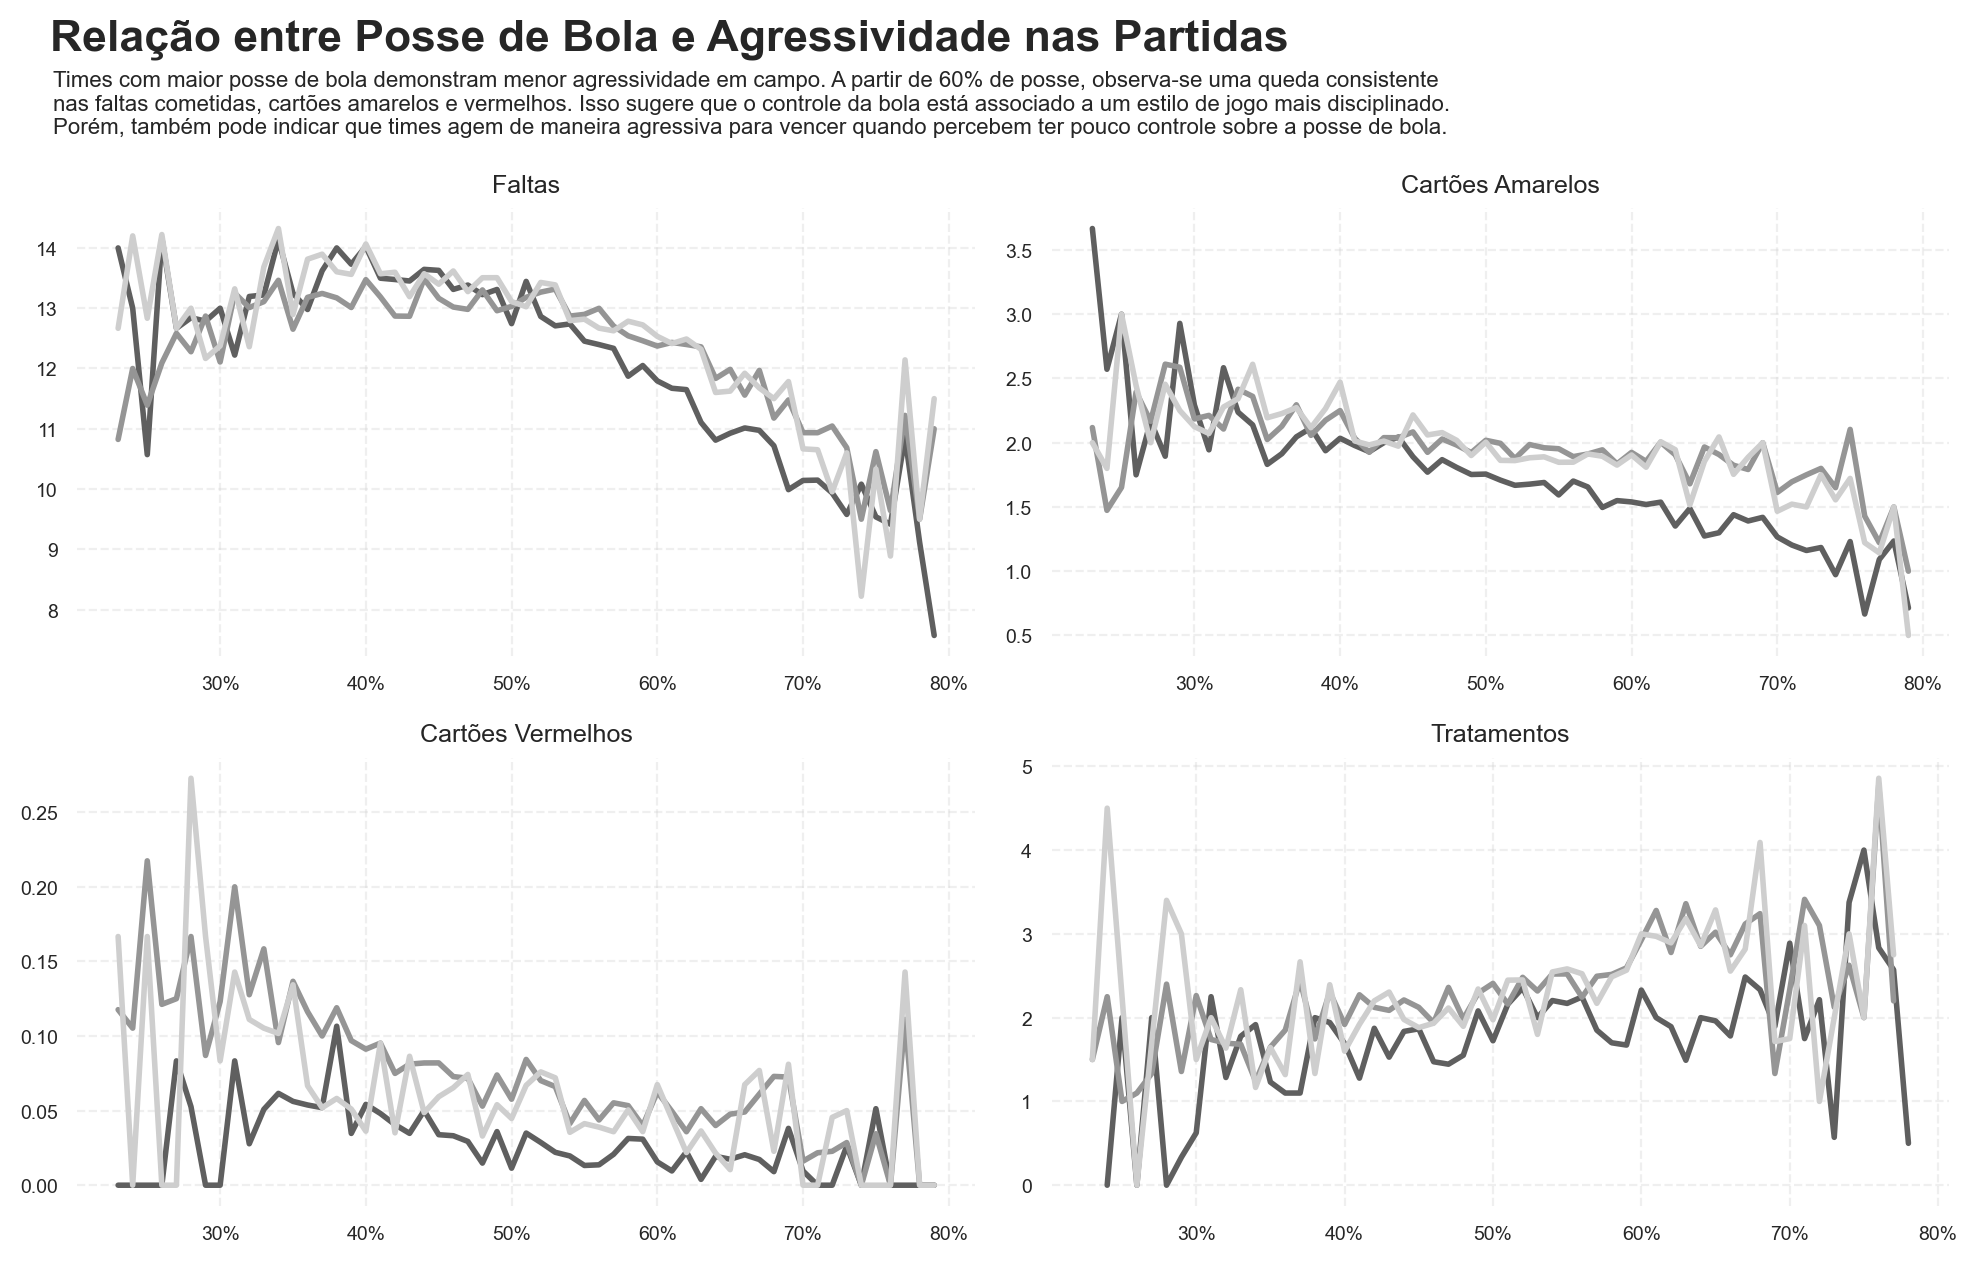

In [319]:
aux = df[(df["Posse 1(%)"] > 22.0) & (df["Posse 1(%)"] < 80.0)]
colunas_interesse = ["Faltas 1", "Cartões amarelos 1", "Cartões vermelhos 1", "Tratamentos 2"]
titulos = ["Faltas", "Cartões Amarelos", "Cartões Vermelhos", "Tratamentos"]

fig, axs = plt.subplots(2, 2, figsize=(10, 6), dpi=200)
axs = axs.flatten()
# Loop para gerar os gráficos
for idx, coluna in enumerate(colunas_interesse):
    sns.lineplot(data=aux[aux["Time 1"] == aux["Vencedor"]], x="Posse 1(%)", y=coluna, linewidth=2, color=plt.cm.Greys(0.7), ax=axs[idx], errorbar=None)
    sns.lineplot(data=aux[aux["Time 1"] != aux["Vencedor"]], x="Posse 1(%)", y=coluna, linewidth=2, color=plt.cm.Greys(0.5), ax=axs[idx], errorbar=None)
    sns.lineplot(data=aux[aux["Vencedor"] == "Empate"], x="Posse 1(%)", y=coluna, linewidth=2, color=plt.cm.Greys(0.3), ax=axs[idx], errorbar=None)

    # Estilização dos plots
    for spine in axs[idx].spines.values(): spine.set_visible(False)
    axs[idx].grid(True, linestyle='--', alpha=0.3)
    axs[idx].set_xlabel("")
    axs[idx].set_ylabel("")
    axs[idx].set_title(titulos[idx], fontsize = 9)
    axs[idx].xaxis.set_major_formatter(PercentFormatter(xmax=100))
    axs[idx].tick_params(axis='both', labelsize=7)
    
fig.suptitle('Relação entre Posse de Bola e Agressividade nas Partidas', x=0.03, ha="left", fontsize=16, fontweight='bold', y=1.045)
fig.text(0.0315, 0.95, f'Times com maior posse de bola demonstram menor agressividade em campo. A partir de 60% de posse, observa-se uma queda consistente\nnas faltas cometidas, cartões amarelos e vermelhos. Isso sugere que o controle da bola está associado a um estilo de jogo mais disciplinado.\nPorém, também pode indicar que times agem de maneira agressiva para vencer quando percebem ter pouco controle sobre a posse de bola.', fontsize = 8)
plt.tight_layout()
plt.show()

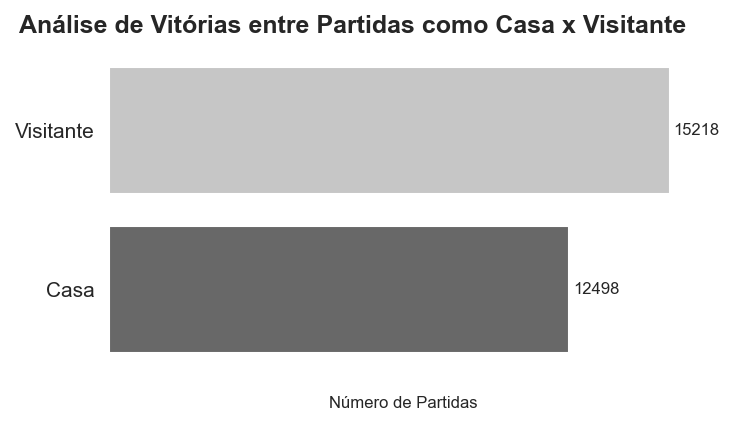

In [320]:
# Lógica para criar as colunas necessárias
aux = df.groupby("Vencedor")["Vitória em Casa"].value_counts().reset_index() 
aux.columns = ["Vencedor", "Vitória em Casa", "Contagem"]
aux1 = aux.groupby("Vitória em Casa")["Contagem"].sum().reset_index()
aux1.columns = ["Vitória em Casa", "Contagem"]
aux1 = aux1.replace({1 : "Casa", 0 : "Visitante"})

# Lógica do gráfico
fig, ax = plt.subplots(figsize=(5, 3), dpi = 150)
bar_plot = sns.barplot(y="Vitória em Casa", x="Contagem", hue = "Vitória em Casa", data=aux1, palette="Greys", ax=ax)
ax.set_xlabel("Número de Partidas", fontsize = 8, labelpad = 13)
ax.set_ylabel("")
ax.set_xticks([])
ax.tick_params(axis='x', labelsize=7, length=-10)
for spines in ax.spines.values(): spines.set_visible(False)

# Anotações ao lado das barras 
for p in bar_plot.patches:
    ax.annotate(f'{int(p.get_width())}',(p.get_width() + 111, p.get_y() + p.get_height() / 2), ha='left', va='center', fontsize=8)

fig.suptitle('Análise de Vitórias entre Partidas como Casa x Visitante', x=0.036, ha="left", fontsize=12, fontweight='bold', y=0.93)
plt.tight_layout()
plt.show()

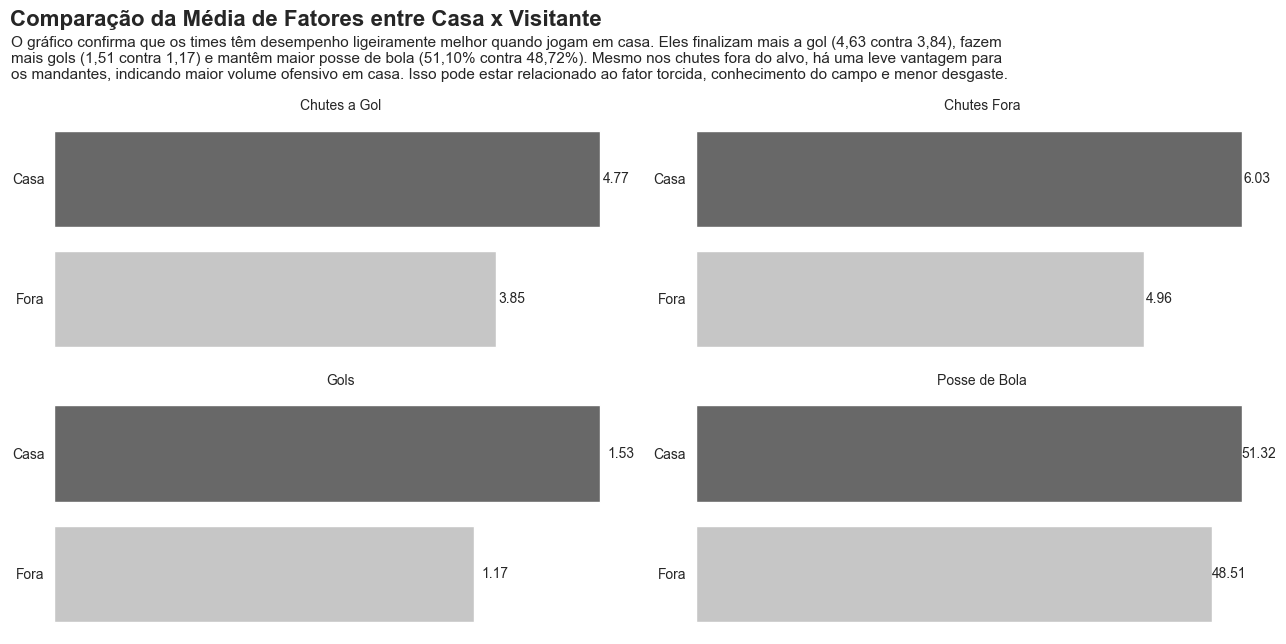

In [321]:
# Cria DataFrames separados para casa e fora
df_mandante = pd.DataFrame({
    'Chutes a gol': df['Chutes a gol 1'],
    'Chutes fora': df['Chutes fora 1'],
    'Gols': df['Gols 1'],
    'Posse de bola': df['Posse 1(%)'],
    'Local': 'Casa'
})

df_visitante = pd.DataFrame({
    'Chutes a gol': df['Chutes a gol 2'],
    'Chutes fora': df['Chutes fora 2'],
    'Gols': df['Gols 2'],
    'Posse de bola': df['Posse 2(%)'],
    'Local': 'Fora'
})

# Concatena os dados
df_comparativo = pd.concat([df_mandante, df_visitante], ignore_index=True)

colunas_interesse = ['Chutes a gol', 'Chutes fora', 'Gols', 'Posse de bola']
titulos = ['Chutes a Gol', 'Chutes Fora', 'Gols', 'Posse de Bola']

# Criar subplots
fig, axs = plt.subplots(2, 2, figsize=(13, 6), dpi=100)
axs = axs.flatten()

# Gerando os gráficos
for idx, coluna in enumerate(colunas_interesse):
    aux = df_comparativo.groupby('Local')[coluna].mean().reset_index()
    bar_plot = sns.barplot(data=aux, x=coluna, y='Local', hue = "Local", ax=axs[idx], palette='Greys_r', orient = "horizontal", legend = False)

    # Estilização dos plots
    axs[idx].set_title(titulos[idx], fontsize=10)
    axs[idx].set_xlabel("")
    axs[idx].set_ylabel("")
    axs[idx].grid(False)
    axs[idx].set_xticks([])
    for spine in axs[idx].spines.values(): spine.set_visible(False)
    
    for p in bar_plot.patches:
        axs[idx].annotate(f'{(p.get_width()):.2f}',(p.get_width() + 0.02, p.get_y() + p.get_height() / 2), ha='left', va='center', fontsize=10)

# Título principal
fig.suptitle('Comparação da Média de Fatores entre Casa x Visitante', x=0.01, ha="left", fontsize=16, fontweight='bold', y=1.065)
fig.text(0.011, 0.95, f'O gráfico confirma que os times têm desempenho ligeiramente melhor quando jogam em casa. Eles finalizam mais a gol (4,63 contra 3,84), fazem\nmais gols (1,51 contra 1,17) e mantêm maior posse de bola (51,10% contra 48,72%). Mesmo nos chutes fora do alvo, há uma leve vantagem para\nos mandantes, indicando maior volume ofensivo em casa. Isso pode estar relacionado ao fator torcida, conhecimento do campo e menor desgaste.', fontsize = 11)
plt.tight_layout()
plt.show()

# Imputação de Valores Faltantes

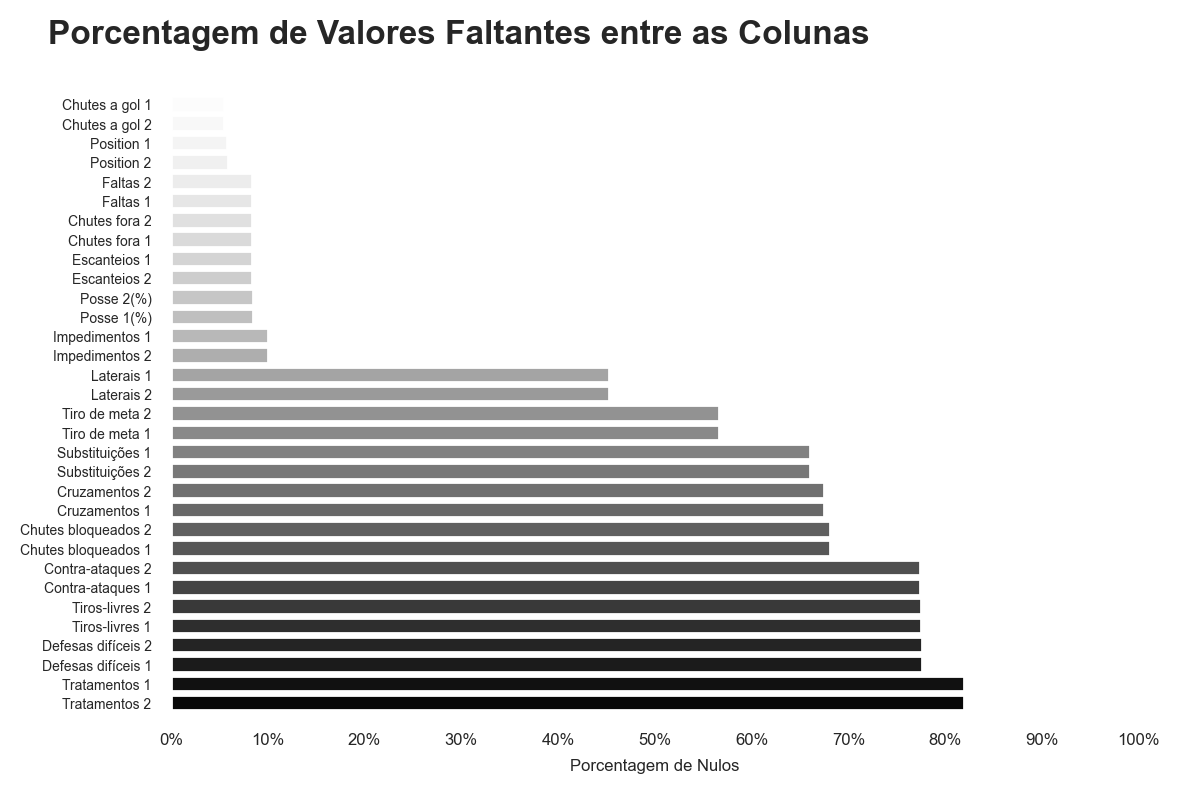

In [322]:
# Visualizando a porcentagem de valores faltantes por coluna
tu.missplot(df)

In [323]:
# Eliminar colunas acima de 60%
aux = tu.na_percent(df)
aux = aux.reset_index()
aux.columns = ["Coluna", "Porcentagem"]

# Eliminando colunas com mais de 60% de valores faltantes
for coluna in aux[aux["Porcentagem"] >= 0.6]["Coluna"]:
    df = df.drop(coluna, axis=1)

# Aplicando a função de preenchimento de valores faltantes, e exibindo o resultado
tu.custom_fillna(df)
tu.missplot(df)

Todos os valores NaN foram eliminados!


# Remoção de Outliers

In [324]:
# Removendo outliers utilizando a função de IQR
for coluna in ["Chutes a gol 1", "Chutes a gol 2", "Chutes fora 2", "Faltas 1", "Faltas 2"]:
    df = tu.removedor_outliers(df, coluna, fator=2)

Chutes a gol 1: 276 outliers removidos.
Chutes a gol 2: 154 outliers removidos.
Chutes fora 2: 63 outliers removidos.
Faltas 1: 121 outliers removidos.
Faltas 2: 24 outliers removidos.


# Encoding de Variáveis Categóricas

In [325]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

#conjunto de todas as formações
AllPositions = set(df["Position 1"]) | set(df["Position 2"])
AllPositions = list(AllPositions)

#df com todas as formações
ps = pd.DataFrame({"Positions": AllPositions})

#codificando para numérico
encoder = OrdinalEncoder()
ps["Positions Encoded"] = encoder.fit_transform(ps[["Positions"]])

#criando dicionário
PositionsDict = dict(zip(ps["Positions"], ps['Positions Encoded']))

#substituindo no df com os valores do dicionário
df["Position 1"] = df["Position 1"].replace(PositionsDict)
df["Position 2"] = df["Position 2"].replace(PositionsDict)

#conjunto de todos os times
AllTeams = set(df["Time 1"]) | set(df["Time 2"]) | set(df["Vencedor"])
AllTeams = list(AllTeams)

#AllTeamsEmpate = AllTeams + ['Empate']
#df com todos os times
ps = pd.DataFrame({"Teams": AllTeams})

#codificando para numérico
encoder = OrdinalEncoder()
ps["Teams Encoded"] = encoder.fit_transform(ps[["Teams"]])

#criando dicionário
TeamsDict = dict(zip(ps["Teams"], ps['Teams Encoded']))

#substituindo no df com os valores do dicionário
df["Time 1"] = df["Time 1"].replace(TeamsDict)
df["Time 2"] = df["Time 2"].replace(TeamsDict)
df["Vencedor"] = df["Vencedor"].replace(TeamsDict)

df.head(10)

,Chutes a gol 1,Chutes a gol 2,Impedimentos 1,Impedimentos 2,Escanteios 1,Escanteios 2,Chutes fora 1,Chutes fora 2,Faltas 1,Faltas 2,...,Tiro de meta 1,Tiro de meta 2,Posse 1(%),Posse 2(%),Time 1,Time 2,Position 1,Position 2,Vencedor,Vitória em Casa
0,8.0,0.0,6.0,3.0,7.0,1.0,6.0,1.0,8.0,14.0,...,10.0,5.432626,77.0,23.0,119.0,171.0,22.0,22.0,119.0,1
1,0.0,2.0,0.0,2.0,0.0,4.0,3.0,4.0,19.0,14.0,...,9.0,6.432626,44.0,56.0,236.0,260.0,11.0,11.0,92.0,0
2,4.0,5.0,1.0,5.0,8.0,11.0,2.0,5.0,13.0,14.0,...,8.0,7.432626,47.0,53.0,85.0,259.0,22.0,7.0,92.0,0
3,4.0,7.0,8.0,1.0,6.0,5.0,4.0,7.0,4.0,11.0,...,7.0,8.432626,27.0,73.0,129.0,68.0,9.0,19.0,129.0,1
4,3.0,1.0,1.0,3.0,5.0,4.0,2.0,2.0,12.0,17.0,...,6.0,9.432626,58.0,42.0,3.0,86.0,24.0,10.0,3.0,1
5,5.0,5.0,1.0,0.0,2.0,4.0,3.0,7.0,21.0,11.0,...,3.0,12.432626,43.0,57.0,191.0,134.0,19.0,19.0,134.0,0
6,2.0,2.0,0.0,1.0,5.0,8.0,1.0,7.0,11.0,8.0,...,8.0,7.432626,32.0,68.0,86.0,119.0,19.0,22.0,86.0,1
7,3.0,4.0,5.0,1.0,4.0,0.0,3.0,6.0,11.0,11.0,...,4.0,11.432626,49.0,51.0,259.0,129.0,19.0,8.0,129.0,0
9,4.0,3.0,2.0,1.0,6.0,2.0,6.0,7.0,21.0,12.0,...,7.0,8.432626,37.0,63.0,171.0,3.0,22.0,16.0,3.0,0
10,4.0,5.0,4.0,1.0,8.0,6.0,5.0,5.0,12.0,10.0,...,8.0,7.432626,52.0,48.0,260.0,191.0,8.0,19.0,92.0,0


# Padronização dos Dados

In [326]:
from sklearn.preprocessing import StandardScaler

# Não normalizando a variável target do dataset
colunas_normalizar = df.columns.difference(['Vencedor', 'Position 2', 'Position 1', 'Time 2', 'Time 1'])
scaler = StandardScaler()

# Aplicar o scaler apenas às colunas desejadas
df_scaled_values = scaler.fit_transform(df[colunas_normalizar])

# Recriar o DataFrame normalizado
df_normalizado = pd.DataFrame(df_scaled_values, columns=colunas_normalizar, index=df.index)
df_normalizado['Vencedor'] = df['Vencedor'].astype(int)
df_normalizado['Position 1'] = df['Position 1'].astype(int)
df_normalizado['Position 2'] = df['Position 2'].astype(int)
df_normalizado['Time 1'] = df['Time 1'].astype(int)
df_normalizado['Time 2'] = df['Time 2'].astype(int)

df_normalizado.head(10)

,Cartões amarelos 1,Cartões amarelos 2,Cartões vermelhos 1,Cartões vermelhos 2,Chutes a gol 1,Chutes a gol 2,Chutes fora 1,Chutes fora 2,Escanteios 1,Escanteios 2,...,Posse 1(%),Posse 2(%),Tiro de meta 1,Tiro de meta 2,Vitória em Casa,Vencedor,Position 1,Position 2,Time 1,Time 2
0,-1.377790,2.041597,-0.219596,-0.23547,1.332337,-1.708177,0.020301,-1.479647,0.524811,-1.374772,...,2.666007,-2.653938,1.082007,-1.019645,1.108358,119,22,22,119,171
1,1.581795,-0.794851,-0.219596,-0.23547,-1.831620,-0.819576,-0.937372,-0.369350,-1.905755,-0.197479,...,-0.729573,0.749960,0.717361,-0.676900,-0.902235,92,11,11,236,260
2,0.102003,-0.085739,4.227833,-0.23547,-0.249642,0.513327,-1.256596,0.000749,0.872034,2.549540,...,-0.420884,0.440515,0.352715,-0.334155,-0.902235,92,22,7,85,259
3,-1.377790,-1.503963,-0.219596,-0.23547,-0.249642,1.401929,-0.618148,0.740947,0.177587,0.194952,...,-2.478811,2.503484,-0.011931,0.008590,1.108358,129,9,19,129,68
4,-0.637893,0.623373,-0.219596,-0.23547,-0.645136,-1.263876,-1.256596,-1.109548,-0.169637,-0.197479,...,0.710976,-0.694118,-0.376577,0.351335,1.108358,3,24,10,3,86
5,2.321692,0.623373,-0.219596,-0.23547,0.145853,0.513327,-0.937372,0.740947,-1.211308,-0.197479,...,-0.832469,0.853109,-1.470515,1.379570,-0.902235,134,19,19,191,134
6,1.581795,-0.794851,-0.219596,-0.23547,-1.040631,-0.819576,-1.575820,0.740947,-0.169637,1.372246,...,-1.964329,1.987741,0.352715,-0.334155,1.108358,86,19,22,86,119
7,-0.637893,-0.085739,4.227833,-0.23547,-0.645136,0.069026,-0.937372,0.370848,-0.516860,-1.767204,...,-0.215091,0.234218,-1.105869,1.036825,-0.902235,129,19,8,259,129
9,2.321692,-1.503963,-0.219596,-0.23547,-0.249642,-0.375275,0.020301,0.740947,0.177587,-0.982341,...,-1.449848,1.471999,-0.011931,0.008590,-0.902235,3,22,16,171,3
10,0.102003,-0.085739,-0.219596,-0.23547,-0.249642,0.513327,-0.298923,0.000749,0.872034,0.587384,...,0.093598,-0.075227,0.352715,-0.334155,-0.902235,92,8,19,260,191


# Machine Learning

In [346]:
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Filtrando para apenas times com mais de 50 vitórias
vencedores_validos = df_normalizado['Vencedor'].value_counts()
vencedores_validos = vencedores_validos[vencedores_validos > 50].index
df_normalizado = df_normalizado[df_normalizado['Vencedor'].isin(vencedores_validos)]

# Colunas de variáveis e target
x = df_normalizado.drop(["Vencedor", "Gols 1", "Gols 2", "Vitória em Casa"], axis=1)
y = df_normalizado["Vencedor"].astype(int)

# Encoding extra aparentemente necessário...
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Separando entre treinamento e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=42, stratify=y)

# Definindo modelos para serem testados
modelos = {
    "XGBoost": XGBClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

resultados = {}
for nome, modelo in modelos.items():
    scores = cross_val_score(modelo, x_train, y_train, cv=2, scoring='accuracy')
    resultados[nome] = scores

resultados_df = pd.DataFrame(resultados)
resultados_df.loc['mean'] = resultados_df.mean()
resultados_df.loc['std'] = resultados_df.std()
resultados_df

,XGBoost,Decision Tree
0,0.486722,0.374410
1,0.495801,0.357653
mean,0.491261,0.366031
std,0.004540,0.008378


In [348]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

model = XGBClassifier(
    objective='multi:softmax',
    num_class=140,  
    use_label_encoder=False,
    eval_metric='mlogloss',
    tree_method='gpu_hist',  
    verbosity=0
)

# Parâmetros para testar
param_grid = {
    'n_estimators':  [300, 600],          
    'max_depth': [4, 6],                 
    'learning_rate': [0.1, 0.2],        
}

# GridSearch com validação cruzada
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, scoring='accuracy', verbose=1, n_jobs=6)

# Treinando o modelo
grid_search.fit(x_train, y_train)

# Melhor modelo
best_model = grid_search.best_estimator_
print("Melhores hiperparâmetros:", grid_search.best_params_)

y_pred = best_model.predict(x_test)
print("Acurácia no teste:", accuracy_score(y_test, y_pred))

Fitting 2 folds for each of 8 candidates, totalling 16 fits
Melhores hiperparâmetros: {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 600}
Acurácia no teste: 0.5220403022670025


In [301]:
# TO-DO
# Conferir o melhor modelo
# Fazer Hyperparametertuning
# Conferir precision, recall e F1-Score
# Exibir feature importance
# Exportar modelo para o github